### This file runs a quick test of my local projection model
* Compute an oil shock variable by assuming that oil prices follow an autoregressive process
* Use the difference between fitted model and data to calculate the innovation in the price (the shock)
* use this shock to examine the dynamic impact on the CAD/USD Exchange rate 

First cell below is for data collection from FRED

In [2]:
import pandas as pd
import numpy as np
import config
from fredapi import Fred

# User will need a FRED API key, can sign up for one here https://fred.stlouisfed.org/docs/api/api_key.html
# replace with your own API key: fred = Fred(api_key='YOUR KEY HERE')
fred = Fred(api_key=config.api_key)

"""
DEFINE: fredget() => a function to retrieve series, store info, and plot data 
-----------------------INPUTS -------------------------------
varlist: a list of FRED codes ex. FRED_list = ['GDP','SP500']
start_date & end_date: set the chosen sample ex. start_d ='1990-01-01'
plots (Optional): True/False => set whether to show a preview of the data during collection
freq (Optional): default is not to synchronize frequencies: choose 'm','q','a' if aggregating
name_map (Optional):dict containing remapped variable names for plot default titles
------------------------OUTPUTS -----------------------------
df_collect: the compiled data df with date set as index
info_store: DF containing series info (units, titles, notes, etc.)
"""

def fredget(varlist, start_date, end_date, plots=True,freq="",name_map = dict()):
    df_collect = pd.DataFrame()

    for var in varlist:
        df_add = fred.get_series(var, observation_start = start_date, observation_end=end_date, frequency =freq).to_frame(name = var)
        info_add = fred.get_series_info(var).to_frame(name = var)
        print(var)
        #If user changes the 
        if freq != "":
            info_add.loc['cur_freq', var] = freq
            
        if var in name_map:
            info_add.loc['user_title', var] = name_map[var]
        else:
            info_add.loc['user_title', var] = info_add.loc['title', var]
                    
        if plots == True:
            df_add.plot(y=var, use_index=True, kind='line', title = info_add.loc['user_title', var], ylabel = info_add.loc['units', var] )
            
        if df_collect.empty == True:
            df_collect = df_add
            info_store = info_add
        else:
            df_collect = pd.merge(df_collect, df_add, left_index=True, right_index=True, how='outer')
            info_store = pd.merge(info_store, info_add, left_index=True, right_index=True, how='left')
            
    df_collect.sort_index()
    return df_collect, info_store



DCOILWTICO
DEXCAUS


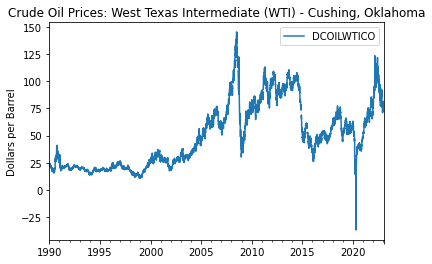

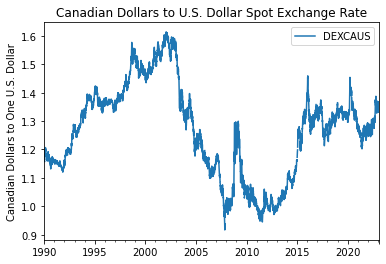

In [3]:
#Data collection
start_d ='1990-01-01'
end_d= '2023-02-03'
fq = "d" 
FRED_list = ['DCOILWTICO','DEXCAUS']
Name_remap = {}

df,dfinfo = fredget(FRED_list, start_d, end_d, freq = fq, plots=True, name_map = Name_remap)

The shape of the df before dropping nans (8196, 17)
The shape of the df AFTER dropping nans (8196, 17)


/Users/wcrossb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'Local projection Response')

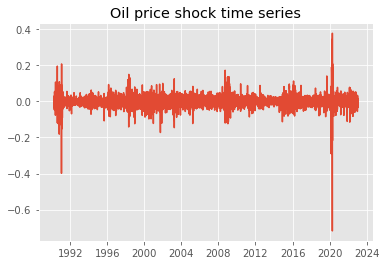

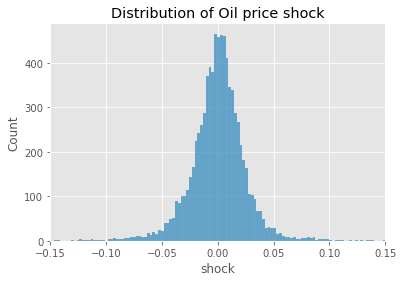

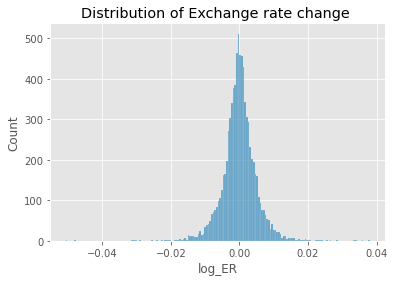

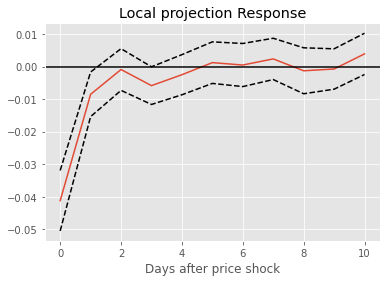

In [6]:
from statsmodels.tsa.ar_model import AutoReg
from lppy import locproj
from matplotlib import pyplot as plt 
import seaborn as sns 
plt.style.use('ggplot')

#Drop missing obs
print(f"The shape of the df before dropping nans {df.shape}")
df.dropna(inplace=True)
print(f"The shape of the df AFTER dropping nans {df.shape}")

#Extract the oil shock and plot its time series 
lag_l =10
df['log_oilprice'] = np.log(df.DCOILWTICO)
df['log_ER'] = np.log(df.DEXCAUS)

#Comptute daily percent changes
df['log_ER'] = df['log_ER'] - df['log_ER'].shift(1)
df.dropna(inplace=True)
armodel = AutoReg(df.log_oilprice,lags=lag_l).fit()
df['shock'] = df.log_oilprice - armodel.fittedvalues

#Plot the oil price shock 
plt.plot(df['shock'])
plt.title('Oil price shock time series')

#Plot the distribution of the shock 
plt.figure()
sns.histplot(df['shock'])
plt.xlim((-.15, .15))
plt.title('Distribution of Oil price shock')

#Plot the distribution of the price change 
plt.figure()
sns.histplot(df['log_ER'])
plt.title('Distribution of Exchange rate change ')

#Add control regressors for LP model
control_names = []
for i in range(1,13):
    df[f'ER_lag{i}'] = df.log_ER.shift(i)
    control_names.append(f'ER_lag{i}')
df = df.tail(-20)

#Set up the data for use with local projection
control_names.append('shock')
exog = df[control_names]
Y = df['log_ER'].to_numpy()

#Calculate local projection and plot the response 
irf = locproj(exog.to_numpy(),Y,12,10,99)
plt.figure()
plt.plot(irf.resp)
plt.plot(irf.se_low,'k--')
plt.plot(irf.se_high,'k--')
plt.xlabel('Days after price shock')
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.title("Local projection Response")  


### Interpretation:
* On impact a shock to oil prices (increase in price) leads to an appreciation of the Canadian Dollar vs. USD 
* This effect is fully incorporated on impact, and is not statistically different from zero at all other horizons
* This reflects efficient market dynamics - we would expect the info to be instantly incorporated